In [2]:
%load_ext autotime

In [3]:
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
pth = r"C:\Users\patrik\Desktop\EPFL\ada" #change location according to your nltk data path
nltk.data.path.append(pth)
lemmatizer = nltk.wordnet.WordNetLemmatizer()

import io
import pandas as pd
import numpy as np
from collections import Counter 
import re

import matplotlib.pyplot as plt
%matplotlib inline

# feature engineering libs
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

#ml libs
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.decomposition import TruncatedSVD
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit

time: 8.95 s


# 1 Data Insight

In [3]:
data_folder = 'twitter-datasets/'

time: 999 µs


In [4]:
def read_data(filepath, proc=False):
    tweets       = []
    tweets_file  = io.open(data_folder + filepath, 'r', encoding='utf8')
    
    for line in tweets_file:
        tw = line.strip()
        tweets.append(tw)
    tweets = pd.DataFrame(tweets, columns=['tweet'])
    if proc:
        tweets = process(tweets)
    return tweets

time: 13 ms


In [5]:
def bag_of_words(x):
    count_vect = CountVectorizer()
    count_x = count_vect.fit(x)
    print('we have {} different words in the dataset'.format(len(count_vect.vocabulary_)))

time: 7 ms


In [6]:
def combine_pos_neg_tweet(pos_file, neg_file, proc=False):
    train_pos = read_data(pos_file, proc)
    train_pos['target'] = 1
    train_neg = read_data(neg_file, proc)
    train_neg['target'] = -1
    train_data = pd.concat([train_neg, train_pos]) #merge positive and negative tweets
    train_data = train_data.sample(frac=1, random_state=42).reset_index(drop=True) #shuffle the datas
    
    print('we have {} positive tweets, and {} negative ones.'.format(len(train_pos), len(train_neg)))
    bag_of_words(train_data['tweet'])
    
    return train_data

time: 7.99 ms


In [7]:
unprocessed_train_data = combine_pos_neg_tweet('train_pos.txt', 'train_neg.txt')

we have 100000 positive tweets, and 100000 negative ones.
we have 100571 different words in the dataset
time: 3.92 s


### data insight for the big dataset

In [8]:
kaggle_data = combine_pos_neg_tweet('train_pos_full.txt', 'train_neg_full.txt')

we have 1250000 positive tweets, and 1250000 negative ones.
we have 493721 different words in the dataset
time: 47.1 s


##### We see that our train dataset as well as the test dataset hav equal number of positive and negative tweets (50%/50%).
##### The train dataset contains around 100K different words, whereas the test dataset contains around 500K words. This is mostly due to the sizes of both datasets (respectively 200K and 2.5M)

# 2 Data Preprocessing

In [9]:
neg_emoji = io.open('opinion-lexicon-english/negative_emojis.txt', encoding='utf-8-sig').read().split("\n")
neg_emoji = dict([x.split() for x in neg_emoji])
pos_emoji = io.open('opinion-lexicon-english/positive_emojis.txt', encoding='utf-8-sig').read().split("\n")
pos_emoji = dict([x.split() for x in pos_emoji])
positive_words = set(io.open('opinion-lexicon-english/positive-words.txt', encoding = "ISO-8859-1").read().split())
negative_words = set(io.open('opinion-lexicon-english/negative-words.txt', encoding = "ISO-8859-1").read().split())

time: 9.99 ms


In [10]:
def remove_contraction(tweets):
    
    contractions_dict = {
        '\'s': '', 'who\'s': 'who is', 'i\'m': 'i am', 'n\'t': 'n not', 'why\'s': 'why is', 'he\'s': 'he is', '\'ll': ' will',
        '\'l': ' will', 'what\'s': 'what is', 'when\'s': 'when is', '\'re': ' are', '\'ve': ' have',
        '\'d': ' would', 'how\'s': 'how is', 'it\'s': 'it is', 'that\'s': 'that is', 's\'': '',
    }
    
    pat = re.compile('|'.join(contractions_dict.keys()))
    tweets =re.sub(r'<user>','',tweets)
    tweets = re.sub(r'<url>','',tweets)
    tweets = re.sub(r'rt','',tweets)
    tweets = pat.sub(lambda x: contractions_dict[x.group()], tweets)
    
    return tweets

def clean_redundant_character(tweet):
    cleaned_tweet = ''
    words = tweet.split()
    
    for word in words:
        cleaned_tweet += re.sub(r'([a-z])\1+$', r'\1 <redundant>' , word) + ' '
    
    return cleaned_tweet.strip() #remove whitespace at end

def handle_hashtag_number(tweet):
    clean_tweet = ''
    words     = tweet.split()
        
    for w in words:
        try:
            remaining = re.sub('[,\.:%_\+\_\%\*\/\-]', '', w)
            float(remaining)
            clean_tweet += '<number> '
        except:
            if w.startswith("#"):
                clean_tweet += w[1:] + ' <hashtag> '
            else:
                clean_tweet += w + ' '
        
    return clean_tweet.strip()

def remove_space_punctuation(tweets):
    puncts = ['?', '.', '!', '+', '(', ')']
    clean_tweets = ''
    first = ''
    j = 0
    for w in tweets.split() : 
        if(w in puncts) :
            if( first != w) : 
                first = w
            else :
                j += 1
                if( j ==1) :
                    clean_tweets += first + ' <repeat> '
        else :
            clean_tweets += w + ' '
    return clean_tweets

def map_sentiment(tweet):

    cleaned_tweet = ''
    words = tweet.split()
    
    #emoji sentiment 
    for word in words:
        if(word in pos_emoji) :
            cleaned_tweet += pos_emoji[word] + ' '
        elif(word in neg_emoji) :
            cleaned_tweet += neg_emoji[word] + ' '
        else : 
            cleaned_tweet += word + ' ' 
    
    cleaned_tweet = cleaned_tweet.split()
    
    #word sentiment
    sentiment_tweet = ''
    for word in cleaned_tweet:
        if(word in positive_words) :
            sentiment_tweet += 'positive ' + word + ' '
        elif(word in negative_words) :
            sentiment_tweet += 'negative ' + word + ' '
        else : 
            sentiment_tweet += word + ' ' 
    return sentiment_tweet.strip()

def stemSentence(tweet):    
    s = tweet.split()
    s = [lemmatizer.lemmatize(x) for x in s]
    return " ".join(s)

time: 21 ms


In [11]:
def process(tweets) :
    tweets.tweet = tweets.tweet.apply(lambda t : remove_contraction(t))
    tweets.tweet = tweets.tweet.apply(lambda t : map_sentiment(t))
    tweets.tweet = tweets.tweet.apply(lambda t : handle_hashtag_number(t))
    tweets.tweet = tweets.tweet.apply(lambda t : remove_space_punctuation(t))
    tweets.tweet = tweets.tweet.apply(lambda t : clean_redundant_character(t))
    tweets.tweet = tweets.tweet.apply(lambda t : stemSentence(t))
    return tweets

time: 13 ms


In [12]:
train_data = combine_pos_neg_tweet('train_neg.txt', 'train_pos.txt', proc=True)

we have 100000 positive tweets, and 100000 negative ones.
we have 88101 different words in the dataset
time: 41.8 s


##### we see that after cleaning the data, we 'loose' around 12K words which is not a bad thing.

In [22]:
X_train, X_test, y_train, y_test = train_test_split(train_data['tweet'], train_data['target'], test_size=0.2, random_state=42)

time: 47 ms


# 3 Feature Engineering

##### after some exploration on CountVectorizer and TfidfVectorizer, we decided to go for tfidf, since it gives us best results as we expected

In [70]:
count_vect = CountVectorizer()
tfidf_vect = TfidfVectorizer(ngram_range=(1,3))

time: 5 ms


In [76]:
X_tfidf = tfidf_vect.fit_transform(X_train)
X_count = count_vect.fit_transform(X_train)

time: 21.2 s


##### we run a grid search over night for PCA and MLP. Since we have not enough power to run MLP over all 440K features (tfidf). We decided to run PCA to reduce the dimensionality to 100, 200 and 500. However the best we achieved was around 80%, which is not so good. We saved our results in csv files in order to avoid to run the code again (6-7 hours). Here is our code and results.

In [20]:
def pca_mlp_parameters(X_pca, train):
    """after manual checking, the interesting parameters are:
        PCA-size: 100,200,300,500,100
        learning rate init: 1e-2,1e-3,1e-4
        learning rate: constant, adaptive, invscaling
        tol: 1e-2,1e-3,1e-4
        hidden layers: (50,), (100,), (150,), (50,20)
        
        A few comments:
        learning rate: constant/adaptive seem good methods, for adaptive don't pick a too big init value(1e-3 too big),
                    it only causes overfitting. constant with 1e-4 or adaptive with 1e-4 seems a good choice.
                    we don't use invscaling, we had bad result.
        tol: the smaller the faster the algorithm ends. 1e-2 causes no overfitting but also not a very good accuracy(77%)
            1e-3 seem a godd value. 1e-4 gave me overfitting...
        hidden layers: nothing to say for now, let's try some values. I mostly tried with (100,)
        PCA-size: for small values, the algorithm has some difficulties to converge. for too big values, it takes a long time.
        """
    HL = [(50,), (100,)]
    LR = [1e-3, 1e-4]
    LRM = ['adaptive', 'constant']
    tol = [1e-3, 1e-4]

    """here are some more parameters
        alpha : 0.0001
        solver : {'lbfgs', 'sgd', 'adam'}
        """
    alpha = [1e-4,1e-3,1e-2,1e-1]


    mlp_grid = {'hidden_layer_sizes': HL,
               'learning_rate_init': LR,
               'learning_rate': LRM,
               'tol': tol,
               'alpha': alpha}
    
    #64 combinations

    mlp_random_collection = []

    for pca in X_pca:
        mlp = MLPClassifier(max_iter=400)
        mlp_random = RandomizedSearchCV(estimator = mlp, param_distributions = mlp_grid, n_iter = 20, cv = 3,\
                           verbose=5, random_state=42, n_jobs = -1, scoring='accuracy', return_train_score=True)
        mlp_random.fit(pca, train)
        mlp_random_collection.append(mlp_random)

    return mlp_random_collection

time: 9 ms


In [ ]:
train_PCA, test_PCA = get_pca(X_train, X_test, (100,200,500))

In [ ]:
### 6-7 hours, mlp collection contains the 3 estimators (pca100, pca200, pca500)
mlp_collection = pca_mlp_parameters(train_PCA, y_train)
### output
'''Fitting 3 folds for each of 20 candidates, totalling 60 fits
    [Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
    [Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:  2.2min
    [Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed: 73.0min finished
    Fitting 3 folds for each of 20 candidates, totalling 60 fits
    [Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
    [Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:  6.6min
    [Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed: 96.9min finished
    Fitting 3 folds for each of 20 candidates, totalling 60 fits
    [Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
    [Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed: 15.3min
    [Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed: 182.6min finished'''

In [24]:
#here are the results for the best parameters for each pca (100, 200, 500)
pd.read_csv('pca_results/test_results.csv')

,Unnamed: 0,test score
0,pca100,0.764775
1,pca200,0.781475
2,pca500,0.802550


time: 16 ms


In [7]:
pca100 = pd.read_csv('pca_results/pca100.csv')
pca200 = pd.read_csv('pca_results/pca200.csv')
pca500 = pd.read_csv('pca_results/pca500.csv')

time: 163 ms


In [17]:
def filter_order_results(mlp_s):
    filtered = []
    for mlp in mlp_s:
        filtered.append(mlp.drop(['std_fit_time','mean_score_time', 'std_score_time','split0_test_score',\
                                 'split1_test_score', 'split2_test_score', 'std_test_score', 'split0_train_score',\
                                 'split1_train_score','split2_train_score', 'std_train_score', 'params'], axis=1))
    return filtered

time: 2 ms


In [18]:
PCAS = filter_order_results([pca100, pca200, pca500])

time: 4.02 ms


In [21]:
#print the pca500 results, which gave the best score
PCAS[2].sort_values(['rank_test_score'])

,Unnamed: 0,mean_fit_time,param_tol,param_learning_rate_init,param_learning_rate,param_hidden_layer_sizes,param_alpha,mean_test_score,rank_test_score,mean_train_score
5,5,420.958774,0.0010,0.0010,constant,"(50,)",0.0100,0.793650,1,0.875281
16,16,972.978627,0.0001,0.0001,adaptive,"(50,)",0.0001,0.791462,2,0.885947
3,3,1155.327422,0.0010,0.0010,constant,"(100,)",0.0100,0.790813,3,0.925506
12,12,887.545906,0.0010,0.0010,adaptive,"(100,)",0.0100,0.788963,4,0.923650
9,9,592.358834,0.0001,0.0010,constant,"(100,)",0.1000,0.788900,5,0.799122
18,18,310.436692,0.0001,0.0010,adaptive,"(50,)",0.1000,0.786956,6,0.796131
10,10,66.365168,0.0010,0.0010,adaptive,"(100,)",0.1000,0.785019,7,0.793206
0,0,69.208062,0.0010,0.0010,constant,"(50,)",0.1000,0.783763,8,0.791403
14,14,270.286611,0.0010,0.0001,adaptive,"(50,)",0.0100,0.778963,9,0.784969
6,6,231.780717,0.0010,0.0010,adaptive,"(50,)",0.0010,0.775369,10,0.918897


time: 26 ms


# 4 Model Selection

##### some helper functions

In [30]:
def find_parameters(X, y, classifier ,parameters, iterations, max_features = None, ngrams = (1,3)):
    """
        X_train: data features
        y_train: data labels
        classifier: classifier used for the random grid search
        parameters: a dict of string/iterable containing the classifier parameters used for the random grid search
        iterations: number of parameter combination to test
        max_features: max features for the tfidf
        ngrams: ngrams for tfidf
        """
    
    
    random_clf = RandomizedSearchCV(estimator = classifier, param_distributions = parameters, n_iter = iterations, cv = 3,\
                                       verbose=5, random_state=42, n_jobs = -1, scoring='accuracy')
    random_pipeline = Pipeline([('tfidf', TfidfVectorizer(max_features=max_features, ngram_range=ngrams)),\
                                ('clf', random_clf)])
    random_pipeline.fit(X, y)
    
    return random_pipeline, random_clf


time: 2 ms


### function found in https://scikit-learn.org/stable/auto_examples/model_selection/plot_learning_curve.html

In [62]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate a simple plot of the test and training learning curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : int, cross-validation generator or an iterable, optional
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:
          - None, to use the default 3-fold cross-validation,
          - integer, to specify the number of folds.
          - :term:`CV splitter`,
          - An iterable yielding (train, test) splits as arrays of indices.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : int or None, optional (default=None)
        Number of jobs to run in parallel.
        ``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.
        ``-1`` means using all processors. See :term:`Glossary <n_jobs>`
        for more details.

    train_sizes : array-like, shape (n_ticks,), dtype float or int
        Relative or absolute numbers of training examples that will be used to
        generate the learning curve. If the dtype is float, it is regarded as a
        fraction of the maximum size of the training set (that is determined
        by the selected validation method), i.e. it has to be within (0, 1].
        Otherwise it is interpreted as absolute sizes of the training sets.
        Note that for classification the number of samples usually have to
        be big enough to contain at least one sample from each class.
        (default: np.linspace(0.1, 1.0, 5))
    """
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes, scoring='accuracy')
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

time: 18 ms


## a) Logistic Regression

##### first we begin by trying on some parameters for the logsitic regression

In [52]:
log_parameter_grid = {'penalty': ['l1','l2'],
                  'C': [9,10, 11],
                  'tol': [1e-4]}

time: 2 ms


In [58]:
log_clf = LogisticRegression()
log_pipeline, log = find_parameters(X_train, y_train, log_clf, parameter_grid, 3)

Fitting 3 folds for each of 3 candidates, totalling 9 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   9 | elapsed:  1.0min remaining:  1.3min
[Parallel(n_jobs=-1)]: Done   6 out of   9 | elapsed:  2.4min remaining:  1.2min
[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed:  2.7min finished
C:\Users\patrik\AppData\Local\conda\conda\envs\ada\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


time: 3min 21s


In [63]:
print('we obtain an accuracy of {}, for {}'.format(clf.best_score_, clf.best_params_))

we obtain an accuracy of 0.83048125, for {'tol': 0.0001, 'penalty': 'l2', 'C': 10}
time: 2 ms


<module 'matplotlib.pyplot' from 'C:\\Users\\patrik\\AppData\\Local\\conda\\conda\\envs\\ada\\lib\\site-packages\\matplotlib\\pyplot.py'>

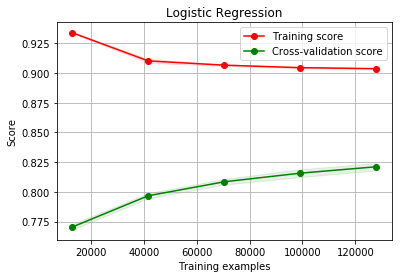

time: 1min 33s


In [72]:
t = clf.best_params_['tol']
p = clf.best_params_['penalty']
c = clf.best_params_['C']
plot_learning_curve(LogisticRegression(), 'Logistic Regression', X_tfidf, y_train, cv=5, n_jobs=-1)

## b) Linear Support Vector Machine

In [43]:
svm_parameter_grid = {'C': [0.001,0.01,0.1,1,10,100]}

time: 999 µs


In [49]:
svm_clf = LinearSVC()
svm_pipeline, svm = find_parameters(X_train, y_train, svm_clf, svm_parameter_grid, 6)

Fitting 3 folds for each of 6 candidates, totalling 18 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:   17.6s
[Parallel(n_jobs=-1)]: Done  15 out of  18 | elapsed:  1.7min remaining:   20.0s
[Parallel(n_jobs=-1)]: Done  18 out of  18 | elapsed:  2.9min finished


time: 3min 19s


In [50]:
print('we obtain an accuracy of {}, for {}'.format(svm.best_score_, svm.best_params_))

we obtain an accuracy of 0.83085625, for {'C': 1}
time: 1e+03 µs


<module 'matplotlib.pyplot' from 'C:\\Users\\patrik\\AppData\\Local\\conda\\conda\\envs\\ada\\lib\\site-packages\\matplotlib\\pyplot.py'>

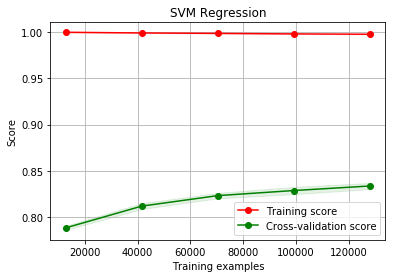

time: 34.8 s


In [75]:
c = clf.best_params_['C']
plot_learning_curve(LinearSVC(), 'SVM Regression', X_tfidf, y_train, cv=5, n_jobs=-1)